# SGLD III: Improved Versions of reSGLD

The advancement from one chain Langevin dynamics to two-chains replica exchange Langevin dynamics was very noticeable. The stochastic gradient version of reLD came out in 2020, and there are recent research papers that try to improve the reSGLD algorithm.

We present in this demo m-reSGLD (Lin et al., 2022).

In [1]:
# general imports
import numpy
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

## A note on estimating gradient

In demo 2, energy function values and gradients were estimated seperately by pulling from a normal distribution. It was unclear if and how the estimated gradient could have related to the estimated function values. 

Moreover, in Li et al. (2023) and Lin et. al (2022), updating schemes are presented in a way such that the variance of the energy function estimator was provided, but the variance on the gradient estimator was not. In general, the gradient is estimated by scaling up a partial sample of gradients. In summary, it is unclear how one can simulate the noise in the gradient estimation. 

In the following demo, we present two ways of estimating gradient.

Method 1: we use a finite difference scheme to approximate gradient. The function values in the finite difference scheme could be non-exact, in which case there is additional random noise to the gradient.

Method 2: as in demo 2, we calculate the exact gradient, and then sample from a normal distribution centered at the exact gradient, with a s.d. to be specified later.

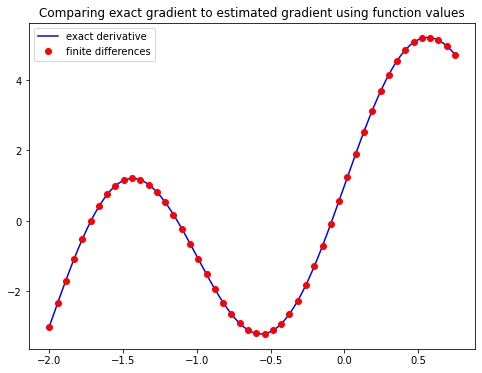

In [2]:
# setup
x = numpy.linspace(-2, 0.75, 1000)
x_dis = numpy.linspace(-2, 0.75, 50)
f = lambda x : x**2 - numpy.cos(numpy.pi*x) + x
f_prime_exact = lambda x : 2*x + numpy.pi * numpy.sin(numpy.pi*x) + 1
f_prime = lambda x, g : (g(x+0.0001) - g(x-0.0001)) / (2*0.0001) 
# def f_prime(x, g):
#     right = g(x+0.0001)
#     left = g(x-0.0001)
#     print("right function value: ", right)
#     print("left function value: ", left)
#     estimate = (g(x+0.0001) - g(x-0.0001)) / (2*0.0001)
#     print("Estimated gradient: ", estimate)
#     return estimate
# the above is a 2nd order accurate approximation of gradient. This way, energy function estimators
# produce estimated gradients, we don't need to add additional noise

# the above is a pretty good estimation scheme
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x, f_prime_exact(x), 'b', label = "exact derivative")
ax.plot(x_dis, f_prime(x_dis, f), 'ro', label = "finite differences")
ax.legend()
ax.set_title("Comparing exact gradient to estimated gradient using function values")
plt.show()


## m-reSGLD: two variances for two energy function estimators

Recall the update scheme in Deng et al. (2020) for reSGLD:

$$
    \hat{\theta}_{k+1}^{(1)} = \hat{\theta}_k^{(1)} - \eta_k \hat{\nabla U}(\theta_k^{(1)}) + \sqrt{2 \eta_k \tau_1}\xi_k^{(1)} \\
    \hat{\theta}_{k+1}^{(2)} = \hat{\theta}_k^{(2)} - \eta_k \hat{\nabla U}(\theta_k^{(2)}) + \sqrt{2 \eta_k \tau_2}\xi_k^{(2)} \\
$$

where $\xi_k^{(1)}$ and $\xi_k^{(2)}$ independently follow the standard normal distribution. In our implementation below, $\hat{\nabla U} \sim N(\nabla U, \sigma_{grad} ^2)$. Deng et al. proposed the following swapping rate using an energy function estimator $\hat{U} \sim N(U, \sigma_{U}^2)$:

$$
    p(swap) = a \eta_k \min{\{1, \exp{[\tau_{\delta}(\hat{U}(x_h^{(1)}) - \hat{U}(x_h^{(2)})-\tau_{\delta}\sigma_{U}^2)]}\}}
$$

In m-reSGLD, the updating scheme stays the same, but the energy estimators for the two chains follow normal distributions with different variances:

$$
    \hat{U_1}(\theta) \sim N(U_1(\theta), \sigma_{1}^2), \hat{U_2}(\theta) \sim N(U_2(\theta), \sigma_{2}^2)
$$

Then, if we use finite difference to estimate the gradient of the energy functions, it is quite conceivable that the gradient estimations would be different for the two chains. Thus the updating scheme is:

$$
    \hat{\theta}_{k+1}^{(1)} = \hat{\theta}_k^{(1)} - \eta_k \hat{\nabla U_1}(\theta_k^{(1)}) + \sqrt{2 \eta_k \tau_1}\xi_k^{(1)} \\
    \hat{\theta}_{k+1}^{(2)} = \hat{\theta}_k^{(2)} - \eta_k \hat{\nabla U_2}(\theta_k^{(2)}) + \sqrt{2 \eta_k \tau_2}\xi_k^{(2)} \\
$$

Correspondingly, the swapping rate is changed in m-reSGLD. The new swapping rate is: 

$$
    p(swap) = a \eta_k \min{\{1, \hat{S}(\hat{\theta}_{k}^{(1)}, \hat{\theta}_{k}^{(2)})\}}, \text{where} \\
    \hat{S}(\theta^{(1)}, \theta^{(2)}) = exp\{\tau_\delta[a_1(\hat{U}_1(\theta^{(1)}) - \hat{U}_1(\theta^{(2)})+a_2(\hat{U}_2(\theta^{(1)}) - \hat{U}_2(\theta^{(2)})-(a_1^2\sigma_1^2 + a_2^2\sigma_2^2)\tau_\delta]\}
$$

where $a_1, a_2$ are nonnegative constants summing to 1.

remark: this new swapping rate calculates the difference between energy function values at $\theta_1 $ and $\theta_2$, with two estimators respectively, and then uses a weighted sum (average) of that difference.

We implement the algorithm below, with two ways of simulating gradient with noise as described above.

### m-reSGLD with finite difference gradient

In [3]:
# define the energy function estimators
n = 1000
s_log_sq = lambda x : 1 / (numpy.log(2*x+1)+5)**2
t_1 = 0.25
t_2 = 2
guess = -1.3
f_approx = lambda x, f, sigma: numpy.random.normal(f(x), sigma)

In [10]:
def m_reSGLD_finite_diff(f, f_approx, f_prime, N, temp_1, temp_2, step, x_0, \
                         a = 0.5, a_1 = 0.5, sigma_1 = 0.001, sigma_2 = 0.005, limit = None):
    '''
    Applies m-reSGLD on designated function
    
    Parameters:
     f: exact energy function
     f_approx: energy function estimator
     f_prime: gradient (finite difference estimate) of energy function
     N: number of iterations
     temp_1: used for low temperature chain
     temp_2: used for high temperature chain
     step: step size, as a function of iteration count, must go to zero
     x_0: initial guess
     limit: a range optinally enforced on x; if x is out of range, then it's forced to the lower or upper bound
     a: parameter relating to swapping probability of the two chains, default 0.5
     sigma_1: standard deviation used for first chain's energy function estimator, default 0.5
     sigma_2: standard deviation used for second chain's energy function estimator, default 2
     a_1: weight on estimator 1
     
    Returns: two numpy arrays of sampled x's, and an array of indices where swap occurred
    '''
    
    chain_1 = numpy.empty(N)
    chain_2 = numpy.empty(N)
    chain_1[0] = x_0
    chain_2[0] = x_0
    swap_count = 0
    swap_idx = []
    f_approx_1 = lambda x : f_approx(x, f, sigma_1)
    f_approx_2 = lambda x : f_approx(x, f, sigma_2)
    
    for k in range(N-1):
        
        tau_del = (1 / temp_1) - (1 / temp_2)
        S_hat = numpy.exp(tau_del * \
                          (a_1 * (f_approx(chain_1[k], f, sigma_1) - f_approx(chain_2[k], f, sigma_1)) + \
                          (1 - a_1) * (f_approx(chain_1[k], f, sigma_2) - f_approx(chain_2[k], f, sigma_2)) - \
                          tau_del * (a_1**2 * sigma_1**2 + (1-a_1)**2 * sigma_2**2)))
        p_swap = a * step(k) * min([1, S_hat])
#         if k < 10:
#             print(p_swap)
            
        rand = numpy.random.uniform(0,1)
        if rand <= p_swap:
            chain_1[k+1] = chain_2[k]
            chain_2[k+1] = chain_1[k]
            #print("Swap occured.")
            swap_count += 1
            swap_idx.append(k)
            
        else:
#             print("Estimated gradient: ")
            grad_1 = f_prime(chain_1[k], f_approx_1)
            grad_2 = f_prime(chain_2[k], f_approx_2)
#             if k < 10:
#                 print(grad_1, grad_2)
            
#             print("Exact gradient for chain_1: ", f_prime_exact(chain_1[k]))
            
            chain_1[k+1] = chain_1[k] - grad_1 * step(k) + \
                           numpy.sqrt(2 * step(k) * temp_1) * (numpy.random.normal(0,1))
            chain_2[k+1] = chain_2[k] - grad_2 * step(k) + \
                           numpy.sqrt(2 * step(k) * temp_2) * (numpy.random.normal(0,1))
            
            # the above gradient approximation is fine.
            # though we evaluated (approximated) f at chain_1[k] and chain_2[k] once already, the approximate
            # gradient function evaluates approximated f at chain_1[k]+/-0.0001, same for chain_2
            # so there is no repeated evaluation
            
        if limit != None:
            if  x_new > limit[1]:
                x_new = limit[1]
            elif x_new < limit[0]:
                x_new = limit[0]
        
    
        
    print("Swap occurred {n} times".format(n=swap_count))
    
    return (chain_1, chain_2, swap_idx)

res_1, res_2, swaps = m_reSGLD_finite_diff(f, f_approx, f_prime, n, temp_1 = t_1, temp_2 = t_2, step = s_log_sq, x_0 = guess, a = 1)
# print(res_1[:50])
# print(max(res_1), min(res_1))



Swap occurred 3 times


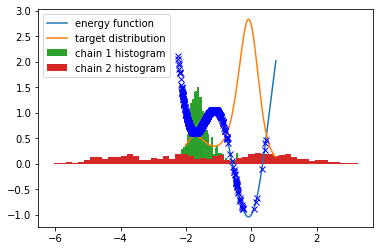

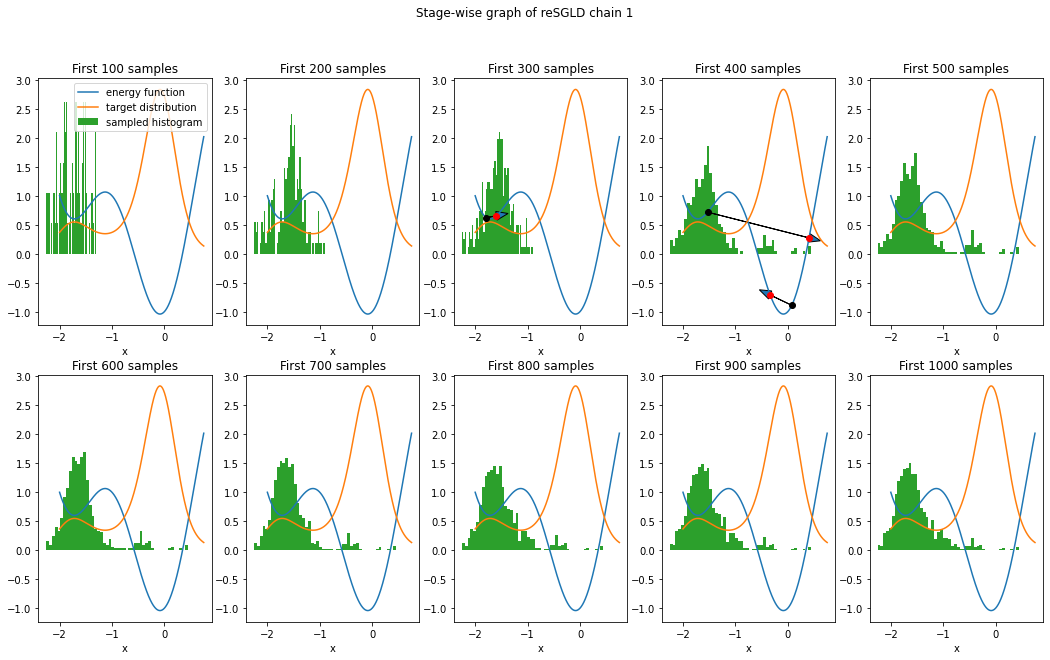

Swap occured at i = : [245, 369, 376]


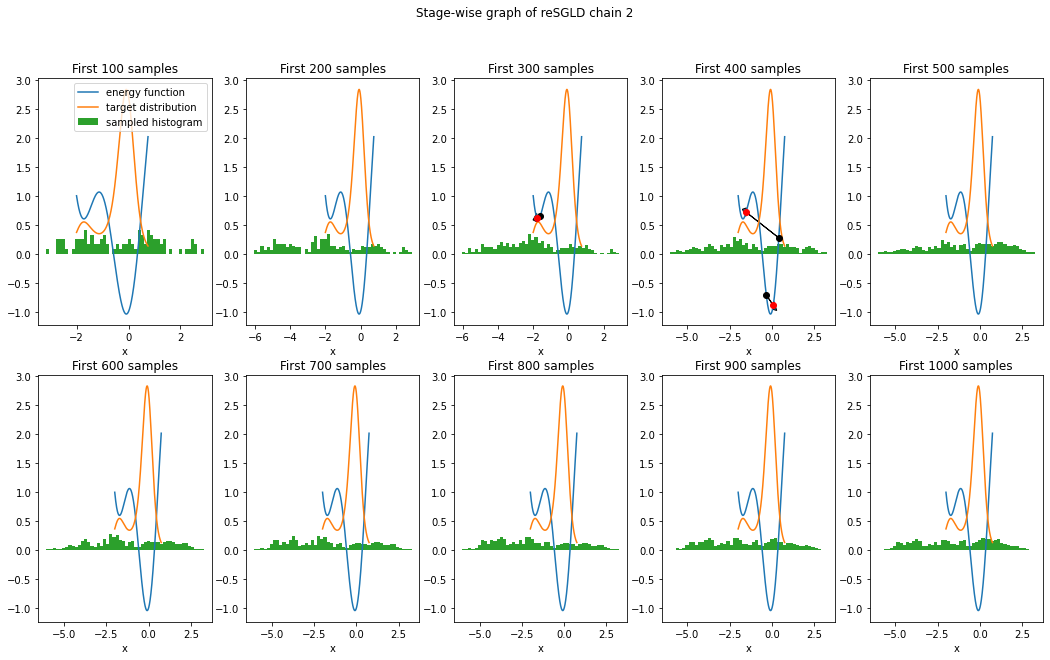

Swap occured at i = : [245, 369, 376]


In [11]:
def plot_two_chains(interval, f, chain_1, chain_2):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(interval, f(interval), label = "energy function")
    ax.plot(interval, numpy.exp(-f(interval)), label = "target distribution")
    ax.hist(chain_1, bins = 50, density = True, label = "chain 1 histogram")
    ax.plot(chain_1, f(chain_1), 'bx')
    ax.hist(chain_2, bins = 50, density = True, label = "chain 2 histogram")
    #ax.plot(chain_2, f(chain_2), 'rx')
    ax.legend()
    #ax.set_xlim(-2, 1)
    plt.show()

def single_chain_stagewise_graph(x, f, chain, title, swaps = None):
    """
    Parameters:
    x: interval in which the function is plotted
    f: the function on which LD was done
    chain: result of samples from the algorithm
    title: name of algorithm, see code below
    swaps: a list of indices where two chains swapped, optional
    """
    
    fig = plt.figure(figsize=(18, 10))
    for i in range(10):
        ax = fig.add_subplot(2, 5, i+1)
        ax.plot(x, f(x), label = "energy function")
        ax.plot(x, numpy.exp(-f(x)), label = "target distribution")
        ax.hist(chain[:len(chain)*(i+1)//10], bins = 50, density = True, label = "sampled histogram")
        #the line below is most useful for small number of iterations
        #ax.plot(chain[:len(chain)*(i+1)//10], f(chain[:len(chain)*(i+1)//10]), 'bx', label = "sampled x")
        if swaps != None:
            for idx in swaps:
                if idx < len(chain)*(i+1) // 10 and idx >= len(chain)*(i) // 10:
                    ax.plot(chain[idx], f(chain[idx]), 'ko')
                    ax.plot(chain[idx+1], f(chain[idx+1]), 'ro')
                    dx = chain[idx+1] - chain[idx]
                    dy = f(chain[idx+1]) - f(chain[idx])
                    ax.arrow(chain[idx], f(chain[idx]), dx, dy, head_width = 0.15)
        if i == 0:
            ax.legend()
        ax.set_xlabel("x")
        ax.set_title("First {n} samples".format(n=len(chain)*(i+1)//10))
    fig.suptitle("Stage-wise graph of {t}".format(t = title, fontsize=14))
    plt.show()
    if swaps != None:
        print("Swap occured at i = :", swaps)

plot_two_chains(x, f, res_1, res_2)
single_chain_stagewise_graph(x, f, res_1, "reSGLD chain 1", swaps)
single_chain_stagewise_graph(x, f, res_2, "reSGLD chain 2", swaps)


- Remark: because of the finite difference scheme includes a very small demonimator, in order to prevent estimated gradient from blowing up, the s.d. provided to energy function estimators need to be very small.

### m-reSGLD with normally distributed gradient

In [6]:
def m_reSGLD_normal(f, f_prime, N, temp_1, temp_2, step, x_0, a_1 = 0.5,\
                    a = 0.5, sigma_1 = 1, sigma_2 = 1, sigma_grad_1 = 1, sigma_grad_2 = 1, limit = None):
    '''
    Applies m-reSGLD on designated function
    
    Parameters:
     f: exact energy function
     f_prime: exact gradient of energy function
     N: number of iterations
     temp_1: used for low temperature chain
     temp_2: used for high temperature chain
     step: step size, as a function of iteration count, must go to zero
     x_0: initial guess
     a_1: weight used in calculating swapping rate, default 0.5
     limit: a range optinally enforced on x; if x is out of range, then it's forced to the lower or upper bound
     a: parameter relating to swapping probability of the two chains, default 0.5
     sigma_1: standard deviation used for first energy function estimator, default 1
     sigma_2: s.d. for second energy function estimator, default 1
     sigma_grad_1: s.d. used for first gradient estimator, default 1
     sigma_grad_2: s.d. used for second gradient estimator, default 1
     
    Returns: two numpy arrays of sampled x's, and an array of indices where swap occurred
    '''
    
    chain_1 = numpy.empty(N)
    chain_2 = numpy.empty(N)
    chain_1[0] = x_0
    chain_2[0] = x_0
    swap_count = 0
    swap_idx = []
    
    for k in range(N-1):
        tau_del = (1 / temp_1) - (1 / temp_2)
        S_hat = numpy.exp(tau_del * \
                          (a_1 * (numpy.random.normal(f(chain_1[k]), sigma_1) - numpy.random.normal(f(chain_2[k]), sigma_1)) + \
                          (1 - a_1) * (numpy.random.normal(f(chain_1[k]), sigma_2) - numpy.random.normal(f(chain_2[k]), sigma_2)) - \
                          tau_del * (a_1**2 * sigma_1**2 + (1-a_1)**2 * sigma_2**2)))
        p_swap = a * step(k) * min([1, S_hat])
#         if k < 10:
#             print(p_swap)
        rand = numpy.random.uniform(0,1)
        if rand <= p_swap:
            chain_1[k+1] = chain_2[k]
            chain_2[k+1] = chain_1[k]
            #print("Swap occured.")
            swap_count += 1
            swap_idx.append(k)
        else:
            chain_1[k+1] = chain_1[k] - numpy.random.normal(f_prime(chain_1[k]), sigma_grad_1) * step(k) + \
                           numpy.sqrt(2 * step(k) * temp_1) * (numpy.random.normal(0,1))
            chain_2[k+1] = chain_2[k] - numpy.random.normal(f_prime(chain_2[k]), sigma_grad_2) * step(k) + \
                           numpy.sqrt(2 * step(k) * temp_2) * (numpy.random.normal(0,1))
        if limit != None:
            if  x_new > limit[1]:
                x_new = limit[1]
            elif x_new < limit[0]:
                x_new = limit[0]
        
    
#         if k < 100:
#             print(x_sgd[k])
    print("Swap occurred {n} times".format(n=swap_count))
    
    return (chain_1, chain_2, swap_idx)

res_1_n, res_2_n, swaps_n = m_reSGLD_normal(f, f_prime_exact, n, \
                                            temp_1 = t_1, temp_2 = t_2, step = s_log_sq, \
                                            x_0 = guess, a = 5, sigma_1 = 0.5, sigma_2 = 1, sigma_grad_2 = 1)




Swap occurred 2 times


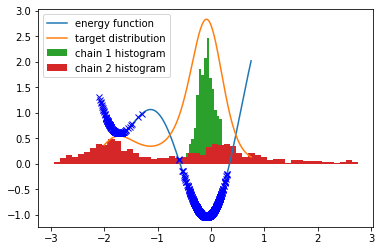

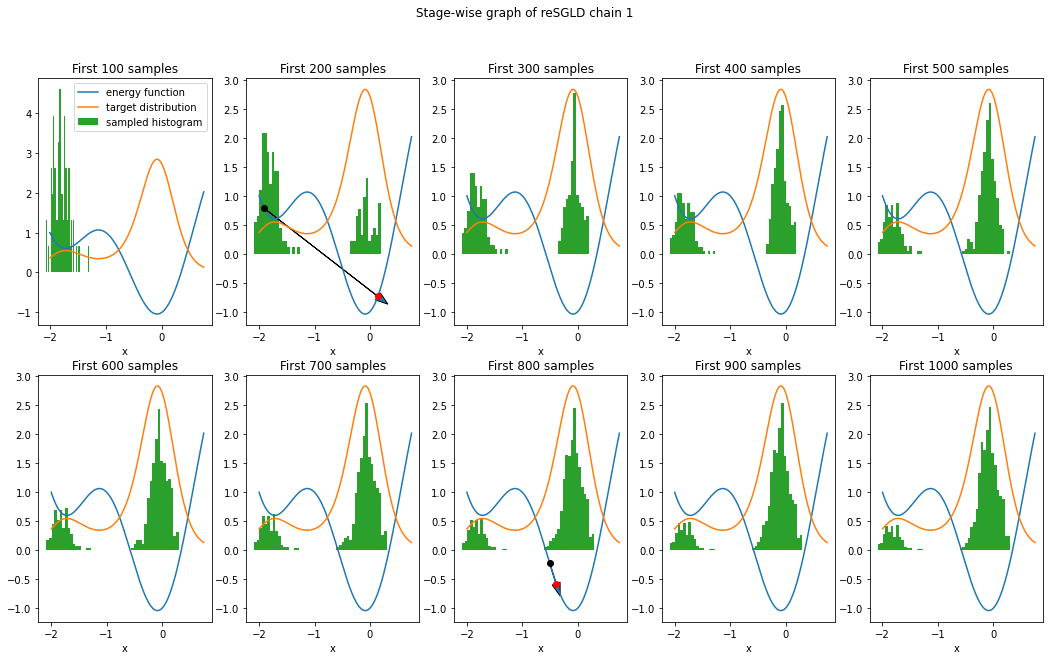

Swap occured at i = : [138, 793]


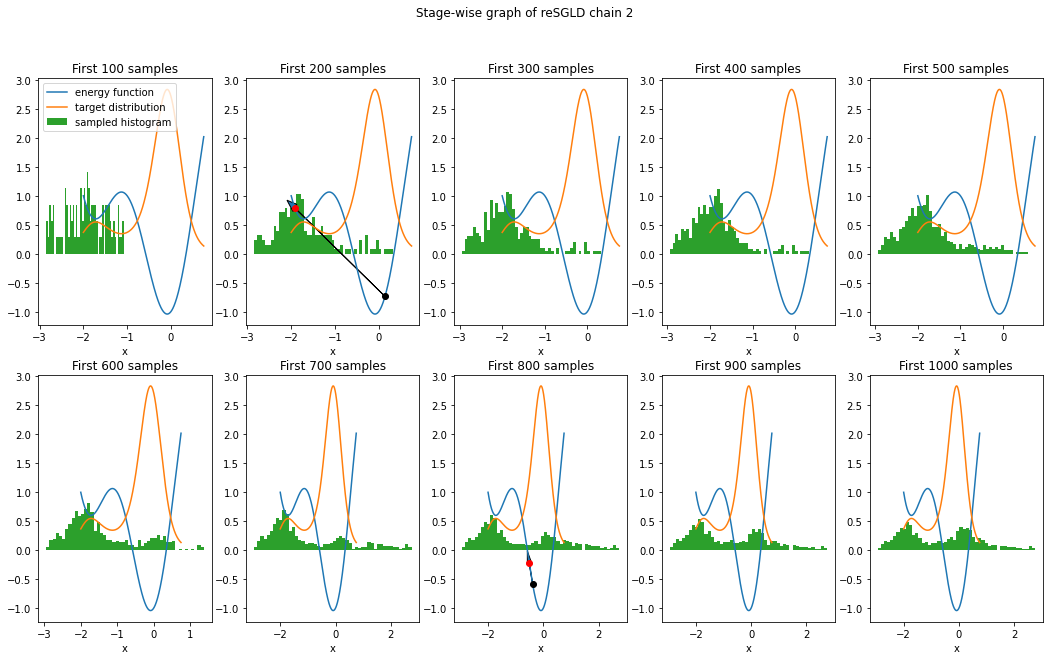

Swap occured at i = : [138, 793]


In [7]:
plot_two_chains(x, f, res_1_n, res_2_n)
single_chain_stagewise_graph(x, f, res_1_n, "reSGLD chain 1", swaps_n)
single_chain_stagewise_graph(x, f, res_2_n, "reSGLD chain 2", swaps_n)



- Remark: in this method the s.d. provided could be much larger.